In [5]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image,ImageOps
from io import BytesIO

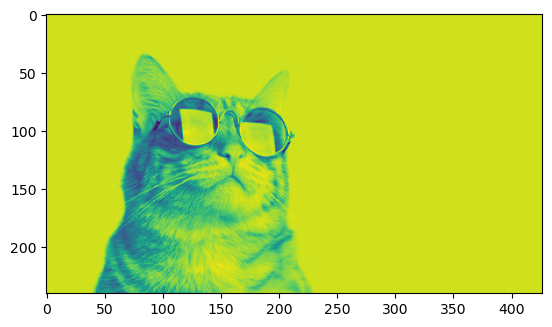

In [11]:
def image(url):
    get = requests.get(url).content
    im = Image.open(BytesIO(get))
    gray = ImageOps.grayscale(im)
    return np.array(gray)

test = image("https://t4.ftcdn.net/jpg/03/03/62/45/240_F_303624505_u0bFT1Rnoj8CMUSs8wMCwoKlnWlh5Jiq.jpg")
plt.imshow(test)
plt.show()

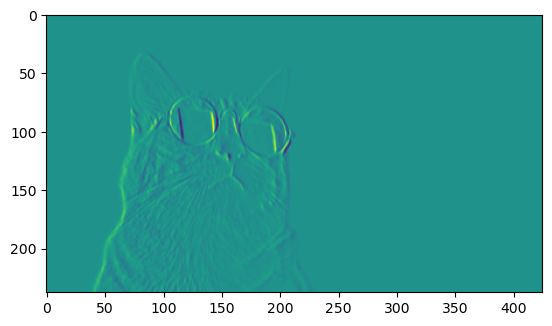

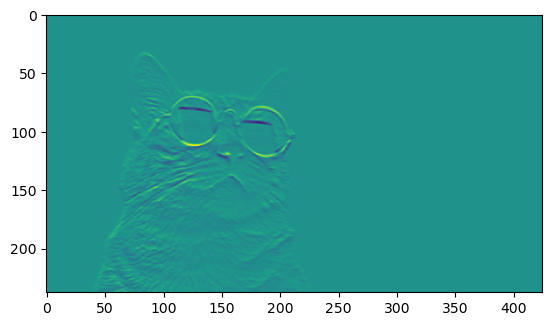

In [13]:
import torch

# torch.nn.Conv2d.weight with shape (out_channels, groups/in_channels, kernel_size[0], kernel_size[1])
# torch.nn.Conv2d(in_channels, out_channels, kernel_size,...)

conv = torch.nn.Conv2d(1,2,3)
conv.weight.data[0,0,:,:] = torch.tensor([[1,0,-1],[1,0,-1],[1,0,-1]]) # vertical
conv.weight.data[1,0,:,:] = torch.tensor([[1,1,1],[0,0,0],[-1,-1,-1]]) # horizontal

out = conv(torch.tensor(test).unsqueeze(0).unsqueeze(0).float())
plt.imshow(out.detach()[0,0])
plt.show()
plt.imshow(out.detach()[0,1])
plt.show()

In [15]:
convnet = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16,16,3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16,32,2)
)

x = torch.randn(123,1,28,28)
print(convnet(x).shape)

torch.Size([123, 32, 4, 4])


In [18]:
convnet = torch.nn.Sequential(
    torch.nn.Unflatten(-1,(1,28,28)),
    torch.nn.Conv2d(1,16,5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16,16,3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16,32,2),
    torch.nn.Flatten()
)

y = torch.randn(123,784)
print(convnet(y).shape)

torch.Size([123, 512])


In [20]:
def CNN():
    return torch.nn.Sequential(
        torch.nn.Unflatten(-1,(1,28,28)),
        torch.nn.Conv2d(1,16,5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(16,16,3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(16,32,2),
        torch.nn.Flatten(),        # from above: Output [123,512]
        torch.nn.Linear(512,10)
    )

model = CNN()
print(model(torch.randn(123,28*28)).shape)

torch.Size([123, 10])


In [21]:
import mnist
train_labels = mnist.train_labels()
test_labels = mnist.test_labels()
scale_mean, scale_std = mnist.train_images().mean(),mnist.train_images().std()
train_images = (mnist.train_images()-scale_mean)/scale_std
test_images = (mnist.test_images()-scale_mean)/scale_std

def make_batch(N = 300, collection = 'train'):
    images = train_images if collection == 'train' else test_images
    labels = train_labels if collection == 'train' else test_labels
        
    indices = np.random.choice(np.arange(len(images)), size = (N,), replace = True)
    X = images[indices]
    y = labels[indices]
    return torch.FloatTensor(X.reshape(-1,28*28)),torch.LongTensor(y)

X, y = make_batch();
print(X.shape, y.shape)

torch.Size([300, 784]) torch.Size([300])


In [22]:
def eval_model(model, collection):
    X,y = make_batch(N = 200, collection=collection)
    p = model(X)
    loss = torch.nn.functional.cross_entropy(p,y)
    return loss

def train(model_fn, Nsteps = 200):
    trajectory = []
    model = model_fn()
    optim = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(Nsteps):
        loss = eval_model(model,'train')
        loss.backward()
        optim.step()
        optim.zero_grad()
        with torch.no_grad():
            loss_val = eval_model(model,'test')
        trajectory.append([float(loss),float(loss_val)])
        if i % 100 == 0:
            print(f'loss: {i}: {loss:.4f}')
    return model,np.array(trajectory)

In [24]:
trained_cnn,traj_cnn = train(CNN, Nsteps = 1001)

loss: 0: 2.3369
loss: 100: 0.1678
loss: 200: 0.1863
loss: 300: 0.0806
loss: 400: 0.0410
loss: 500: 0.0458
loss: 600: 0.0281
loss: 700: 0.1076
loss: 800: 0.0452
loss: 900: 0.0615
loss: 1000: 0.0828


In [26]:
from torchvision import transforms

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

def download_image(url):
    get = requests.get(url).content
    im = Image.open(BytesIO(get))
    return im

input_image = download_image('https://t4.ftcdn.net/jpg/03/03/62/45/240_F_303624505_u0bFT1Rnoj8CMUSs8wMCwoKlnWlh5Jiq.jpg')

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\hakon/.cache\torch\hub\v0.10.0.zip
C:\Users\hakon\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hakon\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\hakon/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|███████████████████████████████████████████████████████████████████████████████| 1

In [35]:
# Download ImageNet labels
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")

('imagenet_classes.txt', <http.client.HTTPMessage at 0x2aee0a847f0>)

In [36]:
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
#print(probabilities)

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

sunglasses 0.27760836482048035
tabby 0.21239642798900604
tiger cat 0.11655185371637344
sunglass 0.108481265604496
Egyptian cat 0.0475633330643177


In [37]:
def create_mlp():
    return torch.nn.Sequential(
        torch.nn.Linear(784,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,10),
)

trained_mlp,traj_mlp = train(create_mlp, Nsteps = 1001)

loss: 0: 2.3080
loss: 100: 0.2405
loss: 200: 0.2303
loss: 300: 0.1464
loss: 400: 0.1854
loss: 500: 0.0765
loss: 600: 0.0654
loss: 700: 0.1021
loss: 800: 0.0317
loss: 900: 0.1009
loss: 1000: 0.0391


In [38]:
def count_params(model):
    return sum([p.numel() for p in model.parameters()])

n_cnn = count_params(trained_cnn)
n_mlp = count_params(trained_mlp)

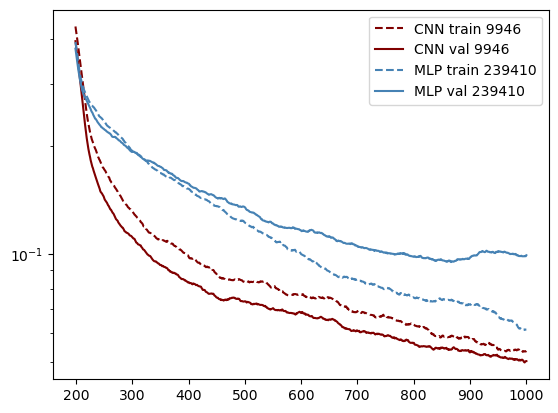

In [40]:
import pandas as pd

plt.plot(pd.DataFrame(traj_cnn[:,0]).rolling(200).mean(),label = f'CNN train {n_cnn}', c = 'maroon', linestyle = 'dashed')
plt.plot(pd.DataFrame(traj_cnn[:,1]).rolling(200).mean(),label = f'CNN val {n_cnn}', c = 'maroon', linestyle = 'solid')

plt.plot(pd.DataFrame(traj_mlp[:,0]).rolling(200).mean(),label = f'MLP train {n_mlp}', c = 'steelblue', linestyle = 'dashed')
plt.plot(pd.DataFrame(traj_mlp[:,1]).rolling(200).mean(),label = f'MLP val {n_mlp}', c = 'steelblue', linestyle = 'solid')
plt.legend()

plt.semilogy()
plt.show()